In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import cv2
# from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, Input.

# from tensorflow.keras.layers import Embedding
# from keras import models
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers # L2규제

from tensorflow.keras.preprocessing.image import ImageDataGenerator # data augmentation
from tensorflow.keras.callbacks import LearningRateScheduler # callbacks 설정

#from tqdm.notebook import tqdm # 모델학습 진행 시간 파악
import random # random seed를 뽑을때 사용

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')


In [7]:
submission = pd.read_csv('data/submission.csv')

In [3]:
#이미지 크기 확대
x_train = train.drop(['id', 'digit', 'letter'], axis=1).values
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') #resize에러 float32로 바꿔 해결함
x_train = [cv2.resize(im,dsize=(84,84),interpolation=cv2.INTER_LINEAR) for im in x_train]
#x_train = x_train/255 # data 정규화
#img=x_train[0].reshape(28,28).astype(int)

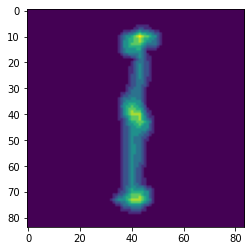

In [4]:
#3배 확대하여 stretching : 오래 걸림.. 컴퓨터야 미안!

def stretch_img(img): #(2048,28,28,1) 반복문으로 넣음
    #img=img.reshape(28,28).astype(int)
    #img=Image.fromarray(img)
    row = 84
    col = 84
    stretch_img = np.zeros((84,84))
    high = 0
    low = 8

    for x in range(1 , row):
        for y in range(1, col):
            if high < img[x,y] :
                high = img[x,y]
            if low > img[x,y]:
                low = img[x,y]
    for x in range(1 , row):
        for y in range(1, col):
            stretch_img[x,y]=int((img[x,y]-low)*8/(high-low))
   
    return stretch_img#스트레칭된 이미지 출력


x__train=[ stretch_img(img) for img in x_train]
plt.imshow(x__train[0])
#stretch_img(x_train[0]) 

In [5]:
def create_cnn_model():
    inputs = Input(shape = (84,84,1))

    bn = tf.keras.layers.BatchNormalization()(inputs)
    conv = tf.keras.layers.Conv2D(64, kernel_size=5, strides=1, padding='same', activation='relu')(bn)
    bn = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Conv2D(64, kernel_size=2, strides=1, padding='same', activation='relu')(bn)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(conv)

    do=tf.keras.layers.Dropout(0.4)(pool)

    bn = tf.keras.layers.BatchNormalization()(do)
    conv = tf.keras.layers.Conv2D(128, kernel_size=5, strides=1, padding='same', activation='relu',kernel_regularizer = regularizers.l2(0.001))(bn)
    bn = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Conv2D(128, kernel_size=2, strides=1, padding='same', activation='relu',kernel_regularizer = regularizers.l2(0.001))(bn)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(conv)

    do=tf.keras.layers.Dropout(0.4)(pool)

    bn = tf.keras.layers.BatchNormalization()(do)
    conv = tf.keras.layers.Conv2D(256, kernel_size=2, strides=1, padding='same', activation='relu',kernel_regularizer = regularizers.l2(0.001))(bn)
    bn = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Conv2D(256, kernel_size=2, strides=1, padding='same', activation='relu',kernel_regularizer = regularizers.l2(0.001))(bn)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(conv)

    flatten = tf.keras.layers.Flatten()(pool)

    bn = tf.keras.layers.BatchNormalization()(flatten)
    dense = tf.keras.layers.Dense(1000, activation='relu')(bn)

    bn = tf.keras.layers.BatchNormalization()(dense)
    outputs = tf.keras.layers.Dense(10, activation='softmax')(bn)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

In [6]:
#1:이진화하여 학습
X__train = [ cv2.threshold(a, 4,8,cv2.THRESH_BINARY)[1] for a in x__train ] #이진화
X__train=np.array(X__train).reshape(-1,84,84,1) 
X__train=X__train/8 #데이터 8비트라서 255보다는 8이 맞지않을까?

#threshold함수는 임계치와 이미지를 return하는것을 잊지말자..

y = train['digit']
y_train = np.zeros((len(y), len(y.unique())))
for i, digit in enumerate(y):
    y_train[i, digit] = 1
    
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

# 이미지 증식 사용
datagen = ImageDataGenerator(
    rotation_range=10,  
    zoom_range = 0.1, 
    width_shift_range=0.1,
    height_shift_range=0.1)

model = create_cnn_model()
epochs=200

#model.fit(x_train, y_train, epochs=50)


history = model.fit(
  datagen.flow(X__train, y_train, batch_size=16),
  epochs=epochs, 
  steps_per_epoch = X__train.shape[0]//16,
  callbacks=[annealer], 
  verbose = 1
)

Epoch 1/200
128/128 [==============================] - 12s 93ms/step - loss: 4.0388 - accuracy: 0.2656
Epoch 2/200
128/128 [==============================] - 12s 93ms/step - loss: 2.7607 - accuracy: 0.3667
Epoch 3/200
128/128 [==============================] - 12s 93ms/step - loss: 2.4462 - accuracy: 0.3877
Epoch 4/200
128/128 [==============================] - 12s 93ms/step - loss: 2.1598 - accuracy: 0.41890s - loss: 2.1
Epoch 5/200
128/128 [==============================] - 12s 93ms/step - loss: 2.0125 - accuracy: 0.4429
Epoch 6/200
128/128 [==============================] - 12s 94ms/step - loss: 1.8293 - accuracy: 0.4653
Epoch 7/200
128/128 [==============================] - 12s 93ms/step - loss: 1.7596 - accuracy: 0.4751
Epoch 8/200
128/128 [==============================] - 12s 94ms/step - loss: 1.6581 - accuracy: 0.4966
Epoch 9/200
128/128 [==============================] - 12s 94ms/step - loss: 1.5844 - accuracy: 0.50881s - loss: 1.5879 - accuracy - ETA: 1s - loss:
Epoch 10/200


128/128 [==============================] - 12s 94ms/step - loss: 0.5178 - accuracy: 0.8643
Epoch 155/200
128/128 [==============================] - 12s 94ms/step - loss: 0.5399 - accuracy: 0.8442
Epoch 156/200
128/128 [==============================] - 12s 94ms/step - loss: 0.5305 - accuracy: 0.8462
Epoch 157/200
128/128 [==============================] - 12s 94ms/step - loss: 0.5343 - accuracy: 0.8428
Epoch 158/200
128/128 [==============================] - 12s 94ms/step - loss: 0.5303 - accuracy: 0.8481
Epoch 159/200
128/128 [==============================] - 12s 94ms/step - loss: 0.5614 - accuracy: 0.8354
Epoch 160/200
128/128 [==============================] - 12s 94ms/step - loss: 0.5450 - accuracy: 0.8403
Epoch 161/200
128/128 [==============================] - 12s 94ms/step - loss: 0.5287 - accuracy: 0.8462
Epoch 162/200
128/128 [==============================] - 12s 94ms/step - loss: 0.5529 - accuracy: 0.8442
Epoch 163/200
128/128 [==============================] - 12s 94ms/ste

In [8]:
x_test = test.drop(['id', 'letter'], axis=1).values
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32')
x_test = [cv2.resize(im,dsize=(84,84),interpolation=cv2.INTER_LINEAR) for im in x_test]
x_test = [cv2.threshold(a, 4,8,cv2.THRESH_BINARY)[1] for a in x_test ] #이진화
x_test = np.array(x_test).reshape(-1, 84, 84, 1)
x_test = x_test/8



submission['digit'] = np.argmax(model.predict(x_test), axis=1)

submission.head(50)


,id,digit
0,2049,8
1,2050,0
2,2051,5
3,2052,2
4,2053,2
5,2054,8
6,2055,8
7,2056,2
8,2057,6
9,2058,8


In [9]:
submission.to_csv('0913_test_thresholdOnly.csv', index=False)

In [10]:
#2: stretch로 학습
x__train=np.array(x__train).reshape(-1,84,84,1) 
x__train=x__train/8 #데이터 8비트라서 255보다는 8이 맞지않을까?

y_ = train['digit']
Y_train = np.zeros((len(y_), len(y_.unique())))
for i, digit in enumerate(y_):
    Y_train[i, digit] = 1
    
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

datagen = ImageDataGenerator(
    rotation_range=10,  
    zoom_range = 0.1, 
    width_shift_range=0.1,
    height_shift_range=0.1)

model = create_cnn_model() #이걸 그대로 쓰면 모델 초기화 되는것임..^^
epochs=200

#model.fit(x_train, y_train, epochs=50)


history = model.fit(
  datagen.flow(x__train, Y_train, batch_size=16),
  epochs=epochs, 
  steps_per_epoch = x__train.shape[0]//16,
  callbacks=[annealer], 
  verbose = 1
)

Epoch 1/200
128/128 [==============================] - 15s 113ms/step - loss: 4.2959 - accuracy: 0.2710
Epoch 2/200
128/128 [==============================] - 15s 115ms/step - loss: 2.7436 - accuracy: 0.3745
Epoch 3/200
128/128 [==============================] - 13s 101ms/step - loss: 2.1863 - accuracy: 0.4805
Epoch 4/200
128/128 [==============================] - 14s 106ms/step - loss: 1.7999 - accuracy: 0.5547
Epoch 5/200
128/128 [==============================] - 12s 96ms/step - loss: 1.5161 - accuracy: 0.6196
Epoch 6/200
128/128 [==============================] - 12s 95ms/step - loss: 1.3894 - accuracy: 0.6299
Epoch 7/200
128/128 [==============================] - 12s 95ms/step - loss: 1.2134 - accuracy: 0.6890
Epoch 8/200
128/128 [==============================] - 12s 95ms/step - loss: 1.1215 - accuracy: 0.6982
Epoch 9/200
128/128 [==============================] - 12s 95ms/step - loss: 1.0265 - accuracy: 0.7212
Epoch 10/200
128/128 [==============================] - 12s 95ms/step

128/128 [==============================] - 12s 96ms/step - loss: 0.1382 - accuracy: 0.9795
Epoch 157/200
128/128 [==============================] - 12s 95ms/step - loss: 0.1475 - accuracy: 0.9766
Epoch 158/200
128/128 [==============================] - 12s 96ms/step - loss: 0.1345 - accuracy: 0.9819
Epoch 159/200
128/128 [==============================] - 12s 96ms/step - loss: 0.1404 - accuracy: 0.9775
Epoch 160/200
128/128 [==============================] - 12s 96ms/step - loss: 0.1346 - accuracy: 0.9761
Epoch 161/200
128/128 [==============================] - 12s 96ms/step - loss: 0.1504 - accuracy: 0.9707
Epoch 162/200
128/128 [==============================] - 12s 95ms/step - loss: 0.1359 - accuracy: 0.9800
Epoch 163/200
128/128 [==============================] - 12s 95ms/step - loss: 0.1380 - accuracy: 0.9775
Epoch 164/200
128/128 [==============================] - 12s 95ms/step - loss: 0.1310 - accuracy: 0.9790
Epoch 165/200
128/128 [==============================] - 12s 96ms/ste

In [15]:
x_test11 = test.drop(['id', 'letter'], axis=1).values
x_test11 = x_test11.reshape(-1, 28, 28, 1).astype('float32')
x_test11 = [cv2.resize(im,dsize=(84,84),interpolation=cv2.INTER_LINEAR) for im in x_test11]
#x_test1 = [cv2.threshold(a, 4,8,cv2.THRESH_BINARY)[1] for a in x_test1 ] #이진화
x_test11=[ stretch_img(img) for img in x_test11] #stretch
x_test11 = np.array(x_test11).reshape(-1, 84, 84, 1)
x_test11 = x_test11/8


submission1 = pd.read_csv('data/submission.csv')
submission1['digit'] = np.argmax(model.predict(x_test11), axis=1)

submission1.head(50)

,id,digit
0,2049,6
1,2050,3
2,2051,8
3,2052,0
4,2053,3
5,2054,7
6,2055,8
7,2056,3
8,2057,4
9,2058,4


In [16]:
submission1.to_csv('0913_test_thresholdNstretching.csv', index=False) #87점..!!